# This notebook is for use on cloud services where interactive use of matplotlib is hard. A script similar to this notebook is in in: snpe/rating_scale_simulator_analysis.py

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Just a formatting related plugin
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [4]:
import sys

sys.path.append("../")

<IPython.core.display.Javascript object>

In [5]:
import multiprocessing as mp

from collections import deque
from pathlib import Path
from typing import Dict, Optional

import arviz
import pickle

import numpy as np
import pandas as pd
import pyreadr
import sbi
import sbi.utils as sbi_utils
import seaborn as sns
import statsmodels.formula.api as smf
import torch

from joblib import Parallel, delayed
from matplotlib.lines import Line2D
from scipy.stats import ttest_ind
from snpe.inference import inference_class
from snpe.simulations import simulator_class, marketplace_simulator_class
from snpe.embeddings.embeddings_to_ratings import EmbeddingRatingPredictor
from snpe.utils.statistics import review_histogram_correlation
from snpe.utils.tqdm_utils import tqdm_joblib
from tqdm import tqdm

# Set plotting parameters
sns.set(style="white", context="talk", font_scale=2.5)
sns.set_color_codes(palette="colorblind")
sns.set_style("ticks", {"axes.linewidth": 2.0})

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<IPython.core.display.Javascript object>

In [6]:
ARTIFACT_PATH = Path("../../../gcs_mount/artifacts/rating_spacing_simulator")
# ARTIFACT_PATH = Path("/data/reputation-systems/snpe/artifacts/rating_spacing_simulator")

<IPython.core.display.Javascript object>

# Functions

In [7]:
def generate_and_save_simulations(
    num_simulations: int,
    review_prior: np.ndarray,
    tendency_to_rate: float,
    simulation_type: str,
    previous_rating_measure: str,
    min_reviews_for_herding: int,
    herding_differentiating_measure: str,
) -> None:
    params = {
        "review_prior": review_prior,
        "tendency_to_rate": tendency_to_rate,
        "simulation_type": simulation_type,
        "previous_rating_measure": previous_rating_measure,
        "min_reviews_for_herding": min_reviews_for_herding,
        "herding_differentiating_measure": herding_differentiating_measure,
    }
    simulator = simulator_class.DoubleHerdingSimulator(params)
    simulator.simulate(num_simulations=num_simulations)
    simulator.save_simulations(ARTIFACT_PATH)

<IPython.core.display.Javascript object>

In [8]:
def infer_and_save_posterior(
    device: str, simulator_type: str, simulation_type: str, params: Dict
) -> None:
    parameter_prior = sbi_utils.BoxUniform(
        low=torch.tensor([0.0, 0.0, 0.0, 0.5, 0.25, 0.25, 0.5, 0.0]).type(
            torch.FloatTensor
        ),
        high=torch.tensor([4.0, 4.0, 1.0, 1.0, 0.75, 0.75, 1.0, 1.0]).type(
            torch.FloatTensor
        ),
        device=device,
    )
    inferrer = inference_class.TimeSeriesInference(
        parameter_prior=parameter_prior, device=device
    )
    inferrer.load_simulator(
        dirname=ARTIFACT_PATH,
        simulator_type=simulator_type,
        simulation_type=simulation_type,
    )
    batch_size = params.pop("batch_size")
    learning_rate = params.pop("learning_rate")
    hidden_features = params.pop("hidden_features")
    num_transforms = params.pop("num_transforms")
    inferrer.infer_snpe_posterior(
        embedding_net_conf=params,
        batch_size=batch_size,
        learning_rate=learning_rate,
        hidden_features=hidden_features,
        num_transforms=num_transforms,
    )
    inferrer.save_inference(ARTIFACT_PATH)

<IPython.core.display.Javascript object>

In [9]:
def sample_posterior_with_observed(
    device: str,
    observations: np.array,
    num_samples: int,
    simulator_type: str,
    simulation_type: str,
) -> np.ndarray:
    # The parameter prior doesn't matter here as it will be overridden by that of the loaded inference object
    parameter_prior = sbi.utils.BoxUniform(
        low=torch.tensor([0.0, 0.0, 0.0, 0.5, 0.25, 0.25, 0.5, 0.0]).type(
            torch.FloatTensor
        ),
        high=torch.tensor([4.0, 4.0, 1.0, 1.0, 0.75, 0.75, 1.0, 1.0]).type(
            torch.FloatTensor
        ),
        device=device,
    )
    inferrer = inference_class.TimeSeriesInference(
        parameter_prior=parameter_prior, device=device
    )
    inferrer.load_simulator(
        dirname=ARTIFACT_PATH,
        simulator_type=simulator_type,
        simulation_type=simulation_type,
    )
    inferrer.load_inference(dirname=ARTIFACT_PATH)
    posterior_samples = inferrer.get_posterior_samples(
        observations, num_samples=num_samples
    )
    return posterior_samples

<IPython.core.display.Javascript object>

In [8]:
def plot_mean_posteriors_for_products(posterior_samples: np.ndarray) -> None:
    fig, ax = plt.subplots(1, 2, squeeze=False)
    ax[0, 0].hist(
        np.mean(posterior_samples[:, :, 0], axis=0),
        color=sns.xkcd_rgb["cerulean"],
        alpha=0.5,
        bins=10,
        label=r"$\rho_{-}$",
    )
    ax[0, 0].hist(
        np.mean(posterior_samples[:, :, 1], axis=0),
        color=sns.xkcd_rgb["dark orange"],
        alpha=0.5,
        bins=10,
        label=r"$\rho_{+}$",
    )
    ax[0, 1].hist(
        np.mean(posterior_samples[:, :, 2], axis=0),
        color=sns.xkcd_rgb["black"],
        alpha=0.5,
        bins=10,
        label=r"$h_p$",
    )
    ax[0, 0].legend(fontsize=20)
    ax[0, 1].legend(fontsize=20)
    ax[0, 0].set_xticks([0, 1, 2, 3, 4])
    ax[0, 1].set_xticks([0, 0.5, 1])
    ax[0, 0].tick_params(axis="both", labelsize=23)
    ax[0, 1].tick_params(axis="both", labelsize=23)
    # add a big axis, hide frame
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor="none", top=False, bottom=False, left=False, right=False)
    # plt.xlabel(r"$\rho_{-}, \rho_{+}$")
    plt.ylabel(
        f"Number of products (Total = {posterior_samples.shape[1]})", fontsize=28
    )
    fig.savefig(ARTIFACT_PATH / "mean_posteriors.png", bbox_inches="tight")

<IPython.core.display.Javascript object>

In [28]:
# In marketplace simulations, we cannot just supply a set of rho params, then simulate and infer on these simulations
# to test if the inference can recover the initially provided params
# So we instead sample from the posterior of a separate set of marketplace simulations not used in training and see
# if parameters are recovered on this new set
def sample_posterior_on_simulations(
    device: str,
    num_samples: int,
    simulator_type: str,
    simulation_type: str,
    max_inference_length: int,
) -> np.ndarray:
    # We load the larger simulation (over 64 marketplaces) as the separate simulation for the inference to be tested on
    params = {
        "review_prior": np.ones(5),
        "tendency_to_rate": 0.05,
        "simulation_type": simulation_type,
        "previous_rating_measure": "mode",
        "min_reviews_for_herding": 5,
        "num_products": 1400,
        # "num_products": 100,
        "num_total_marketplace_reviews": 300_000,
        # "num_total_marketplace_reviews": 5_000,
        "consideration_set_size": 5,
    }
    simulator = marketplace_simulator_class.MarketplaceSimulator(params)
    simulator.load_simulator(ARTIFACT_PATH / "large_simulation")
    # We pick all simulations from a single marketplace as the observations on which we wish to obtain
    # posterior samples
    # These are the observations for the posterior sampling function defined above
    observations = simulator.simulations[0]
    # Also pick the simulation parameters corresponding to these simulations
    simulation_params = simulator.simulation_parameters.copy()
    simulation_params["rho"] = simulation_params["rho"][: len(observations), :]
    simulation_params["h_p"] = simulation_params["h_p"][: len(observations)]
    # Cut the observations to the max length seen during SNPE training
    observations = np.array(
        [obs[:max_inference_length, :] for obs in observations], dtype="object"
    )
    posterior_samples = sample_posterior_with_observed(
        device, observations, num_samples, simulator_type, simulation_type
    )
    return posterior_samples, simulation_params

<IPython.core.display.Javascript object>

# Actual code to run the functions above

In [10]:
torch.set_num_threads(mp.cpu_count())
torch.get_num_threads()

16

<IPython.core.display.Javascript object>

In [11]:
inference_params = {
    "batch_size": 32,
    "learning_rate": 3.2e-4,
    "hidden_features": 30,
    "num_transforms": 7,
    "num_conv_layers": 6,
    "num_channels": 12,
    "conv_kernel_size": 9,
    "maxpool_kernel_size": 17,
    "num_dense_layers": 2,
}

<IPython.core.display.Javascript object>

In [12]:
infer_and_save_posterior("cuda", "marketplace", "timeseries", inference_params)

/opt/conda/lib/python3.7/site-packages/sbi/utils/torchutils.py:28: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  "GPU was selected as a device for training the neural network. "


Embedding net created: 
 Sequential(
  (0): Conv1d(5, 12, kernel_size=(9,), stride=(1,), padding=(4,))
  (1): LeakyReLU(negative_slope=0.01)
  (2): Conv1d(12, 12, kernel_size=(9,), stride=(1,), padding=(8,), dilation=(2,))
  (3): LeakyReLU(negative_slope=0.01)
  (4): Conv1d(12, 12, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
  (5): LeakyReLU(negative_slope=0.01)
  (6): Conv1d(12, 12, kernel_size=(9,), stride=(1,), padding=(32,), dilation=(8,))
  (7): LeakyReLU(negative_slope=0.01)
  (8): Conv1d(12, 12, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
  (9): LeakyReLU(negative_slope=0.01)
  (10): Conv1d(12, 12, kernel_size=(9,), stride=(1,), padding=(128,), dilation=(32,))
  (11): MaxPool1d(kernel_size=17, stride=17, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): LeakyReLU(negative_slope=0.01)
  (14): Linear(in_features=360, out_features=64, bias=True)
  (15): LeakyReLU(negative_slope=0.01)
  (16): Linear(in_feature

/opt/conda/lib/python3.7/site-packages/sbi/utils/user_input_checks.py:697: UserWarning: Parameters theta has device 'cpu'. Moving theta to the data_device 'cuda:0'.Training will proceed on device 'cuda:0'.
  f"Parameters theta has device '{theta.device}'. "


 Neural network successfully converged after 106 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 106
        Best validation performance: 2.7710
        -------------------------
        


<IPython.core.display.Javascript object>

In [30]:
posterior_simulations, simulation_parameters = sample_posterior_on_simulations(
    "cuda", 10_000, "marketplace", "timeseries", 673
)

<IPython.core.display.Javascript object>

In [31]:
posterior_simulations.shape

(10000, 1400, 3)

<IPython.core.display.Javascript object>

In [33]:
simulation_parameters["rho"].shape

(1400, 2)

<IPython.core.display.Javascript object>

In [40]:
save_dict = {
    "posterior_simulations": posterior_simulations,
    "simulation_parameters": simulation_parameters,
}

<IPython.core.display.Javascript object>

In [41]:
with open(ARTIFACT_PATH / "posterior_inference_on_simulations.pkl", "wb") as f:
    pickle.dump(save_dict, f)

<IPython.core.display.Javascript object>

# Working with the observed data

In [7]:
# reviews = pyreadr.read_r(
#    "/data/Dropbox/SNPE/all_data/reviews_bazaarvoice_main_vars.Rds"
# )
reviews = pyreadr.read_r(ARTIFACT_PATH / "reviews_bazaarvoice_main_vars.Rds")
# reviews = pyreadr.read_r(
#    Path("../../../gcs_mount/artifacts/marketplace/")
#    / "reviews_bazaarvoice_main_vars.Rds"
# )
reviews = reviews[None]
reviews.head()

,asin,overall,ReviewId,unixReviewTime,rootcategoryid
0,670155,4,3480905,2009-02-10,33005908
1,670155,3,3535864,2009-02-24,33005908
2,670155,5,3539112,2009-02-24,33005908
3,670155,4,3539514,2009-02-25,33005908
4,670155,1,3556157,2009-03-05,33005908


<IPython.core.display.Javascript object>

In [8]:
pd.testing.assert_frame_equal(reviews, reviews.sort_values(["asin", "unixReviewTime"]))

<IPython.core.display.Javascript object>

In [9]:
reviews.asin.value_counts().max()

1293

<IPython.core.display.Javascript object>

In [10]:
reviews.asin.unique().shape

(1406,)

<IPython.core.display.Javascript object>

In [11]:
reviews.asin.value_counts().describe()

count    1406.000000
mean       96.212660
std       126.677148
min         1.000000
25%        25.250000
50%        51.000000
75%       113.000000
max      1293.000000
Name: asin, dtype: float64

<IPython.core.display.Javascript object>

In [12]:
# Pull out the ratings from the timeseries DF and convert them into a format
# that can be fed into the inference engine
# Also save a list of the asin values to have the order in which products appear in the timeseries list
timeseries_data = []
timeseries_asin = []
for product in reviews.asin.unique():
    # We were cutting off at 5001 reviews earlier when we could control the number of reviews per product in the sims
    # But now, we put the max len of the deque a little higher than the number of reviews
    # for the most reviewed product (around 1300)
    # Actually we have to use the length that the simulations were padded to during inference (=longest simulated
    # review timeseries = 521 in this case). Also remember that we add [1, 1, 1, 1, 1] at the beginning as the
    # starting histogram, so the product ratings need to be cut to 520
    timeseries = deque([np.ones(5)], maxlen=521)
    ratings = np.array(reviews.loc[reviews.asin == product, "overall"])
    ratings = ratings[:520]
    for rating in ratings:
        current_histogram = timeseries[-1].copy()
        current_histogram[int(rating - 1)] += 1
        timeseries.append(current_histogram)
    timeseries_data.append(np.array(timeseries))
    timeseries_asin.append(product)
timeseries_data = np.array(timeseries_data, dtype="object")
timeseries_asin = np.array(timeseries_asin, dtype="int")

<IPython.core.display.Javascript object>

In [13]:
timeseries_data.shape

(1406,)

<IPython.core.display.Javascript object>

In [14]:
timeseries_asin

array([ 670155,  671312, 1017360, ..., 9822904, 9822911, 9827954])

<IPython.core.display.Javascript object>

In [25]:
posterior_samples = sample_posterior_with_observed(
    "cuda", timeseries_data, 10_000, "marketplace", "timeseries"
)

<IPython.core.display.Javascript object>

(array([10., 40., 68., 83., 82., 58., 50., 37., 36., 41., 29., 24., 32.,
        28., 26., 24., 12., 18., 16., 14., 13., 19., 14., 13., 10.,  9.,
        11.,  8.,  9., 12.,  8., 16., 14., 17., 21., 26., 26., 33., 16.,
        29., 37., 60., 53., 36., 38., 34., 29., 17., 38., 12.]),
 array([0.15346995, 0.21795371, 0.28243747, 0.34692123, 0.41140498,
        0.47588874, 0.5403725 , 0.60485626, 0.66934001, 0.73382377,
        0.79830753, 0.86279129, 0.92727504, 0.9917588 , 1.05624256,
        1.12072632, 1.18521007, 1.24969383, 1.31417759, 1.37866135,
        1.4431451 , 1.50762886, 1.57211262, 1.63659637, 1.70108013,
        1.76556389, 1.83004765, 1.8945314 , 1.95901516, 2.02349892,
        2.08798268, 2.15246643, 2.21695019, 2.28143395, 2.34591771,
        2.41040146, 2.47488522, 2.53936898, 2.60385274, 2.66833649,
        2.73282025, 2.79730401, 2.86178777, 2.92627152, 2.99075528,
        3.05523904, 3.1197228 , 3.18420655, 3.24869031, 3.31317407,
        3.37765783]),
 <BarContainer

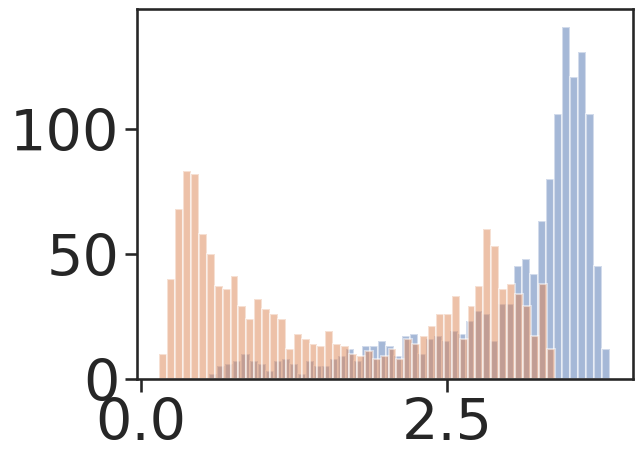

<IPython.core.display.Javascript object>

In [26]:
plt.hist(np.mean(posterior_samples[:, :, 0], axis=0), alpha=0.5, bins=50)
plt.hist(np.mean(posterior_samples[:, :, 1], axis=0), alpha=0.5, bins=50)

(array([16., 58., 99., 80., 87., 89., 94., 80., 95., 77., 65., 52., 46.,
        52., 59., 39., 32., 30., 30., 15., 18., 20., 17., 14., 11., 12.,
        14., 10., 12., 10.,  7.,  6., 11.,  4.,  5., 11.,  1.,  2.,  5.,
         7.,  2.,  4.,  2.,  0.,  0.,  2.,  0.,  1.,  2.,  1.]),
 array([0.02558821, 0.03722501, 0.0488618 , 0.06049859, 0.07213538,
        0.08377217, 0.09540897, 0.10704576, 0.11868255, 0.13031934,
        0.14195614, 0.15359293, 0.16522972, 0.17686651, 0.1885033 ,
        0.2001401 , 0.21177689, 0.22341368, 0.23505047, 0.24668727,
        0.25832406, 0.26996085, 0.28159764, 0.29323443, 0.30487123,
        0.31650802, 0.32814481, 0.3397816 , 0.3514184 , 0.36305519,
        0.37469198, 0.38632877, 0.39796557, 0.40960236, 0.42123915,
        0.43287594, 0.44451273, 0.45614953, 0.46778632, 0.47942311,
        0.4910599 , 0.5026967 , 0.51433349, 0.52597028, 0.53760707,
        0.54924386, 0.56088066, 0.57251745, 0.58415424, 0.59579103,
        0.60742783]),
 <BarContainer

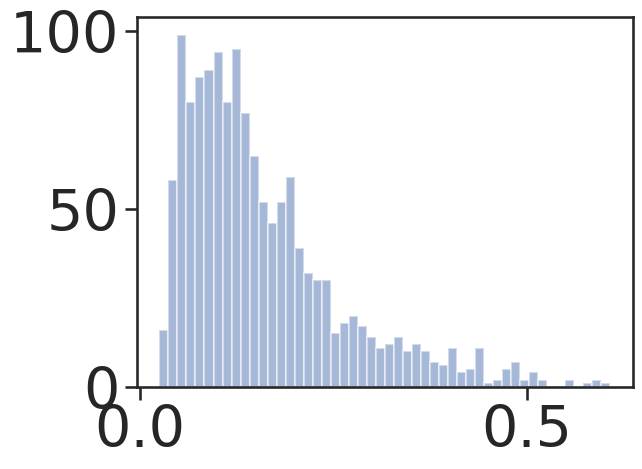

<IPython.core.display.Javascript object>

In [27]:
plt.hist(np.mean(posterior_samples[:, :, 2], axis=0), alpha=0.5, bins=50)

(array([ 1.,  0.,  3.,  6.,  3.,  0.,  8.,  3.,  4.,  8.,  7.,  6.,  3.,
         4., 11.,  8., 10., 16., 22., 30., 54., 50., 38., 35., 34., 35.,
        37., 45., 36., 36., 61., 42., 40., 55., 69., 69., 70., 62., 75.,
        52., 55., 53., 47., 32., 27., 16., 14.,  6.,  3.,  5.]),
 array([0.55827784, 0.56661732, 0.5749568 , 0.58329628, 0.59163576,
        0.59997525, 0.60831473, 0.61665421, 0.62499369, 0.63333317,
        0.64167266, 0.65001214, 0.65835162, 0.6666911 , 0.67503058,
        0.68337007, 0.69170955, 0.70004903, 0.70838851, 0.71672799,
        0.72506748, 0.73340696, 0.74174644, 0.75008592, 0.7584254 ,
        0.76676489, 0.77510437, 0.78344385, 0.79178333, 0.80012281,
        0.8084623 , 0.81680178, 0.82514126, 0.83348074, 0.84182022,
        0.85015971, 0.85849919, 0.86683867, 0.87517815, 0.88351763,
        0.89185712, 0.9001966 , 0.90853608, 0.91687556, 0.92521504,
        0.93355453, 0.94189401, 0.95023349, 0.95857297, 0.96691245,
        0.97525194]),
 <BarContainer

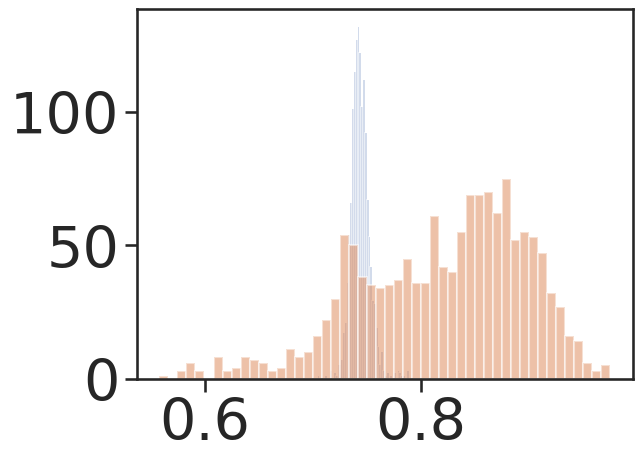

<IPython.core.display.Javascript object>

In [28]:
plt.hist(np.mean(posterior_samples[:, :, 3], axis=0), alpha=0.5, bins=50)
plt.hist(np.mean(posterior_samples[:, :, 6], axis=0), alpha=0.5, bins=50)

(array([ 1.,  8., 12., 11., 25., 22., 33., 44., 32., 40., 39., 48., 42.,
        47., 37., 44., 48., 50., 57., 58., 48., 70., 45., 43., 51., 50.,
        45., 48., 41., 47., 42., 38., 26., 18., 10., 11.,  6., 10.,  7.,
         9.,  8.,  8.,  8.,  5.,  4.,  3.,  3.,  1.,  1.,  2.]),
 array([0.36999468, 0.37404438, 0.37809407, 0.38214376, 0.38619345,
        0.39024314, 0.39429283, 0.39834253, 0.40239222, 0.40644191,
        0.4104916 , 0.41454129, 0.41859099, 0.42264068, 0.42669037,
        0.43074006, 0.43478975, 0.43883945, 0.44288914, 0.44693883,
        0.45098852, 0.45503821, 0.45908791, 0.4631376 , 0.46718729,
        0.47123698, 0.47528667, 0.47933637, 0.48338606, 0.48743575,
        0.49148544, 0.49553513, 0.49958483, 0.50363452, 0.50768421,
        0.5117339 , 0.51578359, 0.51983328, 0.52388298, 0.52793267,
        0.53198236, 0.53603205, 0.54008174, 0.54413144, 0.54818113,
        0.55223082, 0.55628051, 0.5603302 , 0.5643799 , 0.56842959,
        0.57247928]),
 <BarContainer

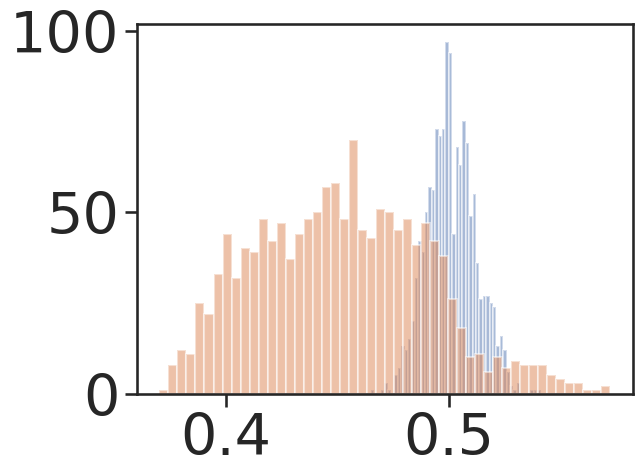

<IPython.core.display.Javascript object>

In [29]:
plt.hist(np.mean(posterior_samples[:, :, 4], axis=0), alpha=0.5, bins=50)
plt.hist(np.mean(posterior_samples[:, :, 5], axis=0), alpha=0.5, bins=50)

(array([ 1.,  0.,  3.,  6.,  3.,  0.,  8.,  3.,  4.,  8.,  7.,  6.,  3.,
         4., 11.,  8., 10., 16., 22., 30., 54., 50., 38., 35., 34., 35.,
        37., 45., 36., 36., 61., 42., 40., 55., 69., 69., 70., 62., 75.,
        52., 55., 53., 47., 32., 27., 16., 14.,  6.,  3.,  5.]),
 array([0.83741675, 0.84992598, 0.8624352 , 0.87494442, 0.88745365,
        0.89996287, 0.91247209, 0.92498131, 0.93749054, 0.94999976,
        0.96250898, 0.97501821, 0.98752743, 1.00003665, 1.01254588,
        1.0250551 , 1.03756432, 1.05007354, 1.06258277, 1.07509199,
        1.08760121, 1.10011044, 1.11261966, 1.12512888, 1.13763811,
        1.15014733, 1.16265655, 1.17516577, 1.187675  , 1.20018422,
        1.21269344, 1.22520267, 1.23771189, 1.25022111, 1.26273034,
        1.27523956, 1.28774878, 1.300258  , 1.31276723, 1.32527645,
        1.33778567, 1.3502949 , 1.36280412, 1.37531334, 1.38782257,
        1.40033179, 1.41284101, 1.42535023, 1.43785946, 1.45036868,
        1.4628779 ]),
 <BarContainer

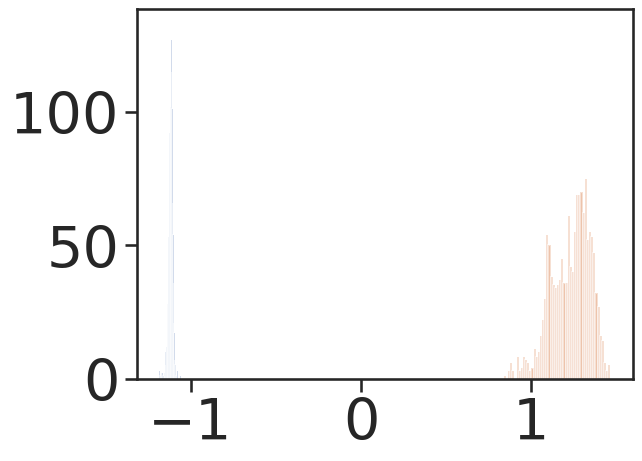

<IPython.core.display.Javascript object>

In [30]:
plt.hist(np.mean(-1.5 * posterior_samples[:, :, 3], axis=0), alpha=0.5, bins=50)
plt.hist(np.mean(1.5 * posterior_samples[:, :, 6], axis=0), alpha=0.5, bins=50)

(array([  4.,   3.,   3.,   2.,   7.,  10.,   5.,  16.,  15.,  11.,  19.,
         11.,  18.,  20.,  25.,  17.,  22.,  33.,  41.,  34.,  58.,  62.,
         77., 101.,  70.,  61.,  51.,  50.,  60.,  60.,  40.,  46.,  45.,
         46.,  38.,  29.,  27.,  33.,  32.,  27.,  18.,  13.,  16.,  15.,
          7.,   1.,   2.,   3.,   0.,   2.]),
 array([0.34966981, 0.3576976 , 0.36572539, 0.37375318, 0.38178097,
        0.38980876, 0.39783655, 0.40586434, 0.41389213, 0.42191992,
        0.42994771, 0.4379755 , 0.44600329, 0.45403108, 0.46205887,
        0.47008666, 0.47811445, 0.48614224, 0.49417003, 0.50219782,
        0.51022561, 0.5182534 , 0.52628119, 0.53430898, 0.54233677,
        0.55036456, 0.55839235, 0.56642014, 0.57444793, 0.58247572,
        0.59050351, 0.5985313 , 0.60655909, 0.61458688, 0.62261467,
        0.63064246, 0.63867025, 0.64669804, 0.65472583, 0.66275362,
        0.67078141, 0.6788092 , 0.68683699, 0.69486478, 0.70289257,
        0.71092036, 0.71894815, 0.72697594, 0.

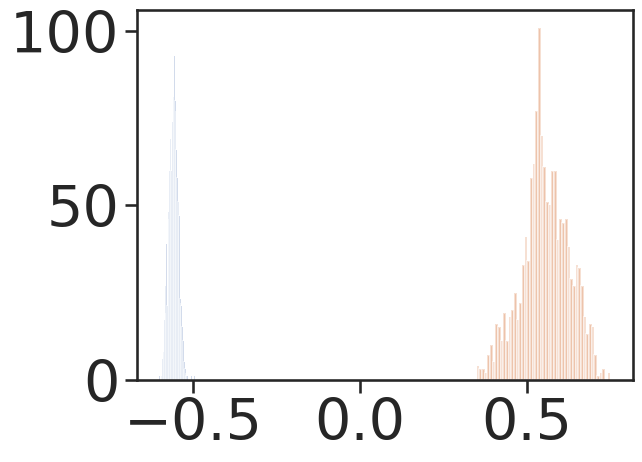

<IPython.core.display.Javascript object>

In [31]:
plt.hist(
    np.mean(-1.5 * posterior_samples[:, :, 3] * posterior_samples[:, :, 4], axis=0),
    alpha=0.5,
    bins=50,
)
plt.hist(
    np.mean(1.5 * posterior_samples[:, :, 6] * posterior_samples[:, :, 5], axis=0),
    alpha=0.5,
    bins=50,
)

(array([ 83., 107.,  87.,  74.,  68.,  76.,  63.,  66.,  56.,  46.,  26.,
         27.,  21.,  23.,  11.,  11.,  23.,   7.,   7.,  12.,  18.,  13.,
         16.,  12.,   8.,  11.,  10.,  13.,  15.,  15.,  16.,  15.,  14.,
         17.,  14.,  11.,   9.,  16.,  15.,  21.,  13.,  18.,  18.,  16.,
         24.,  29.,  30.,  31.,  38.,  16.]),
 array([0.0137084 , 0.02288821, 0.03206802, 0.04124783, 0.05042764,
        0.05960745, 0.06878726, 0.07796707, 0.08714688, 0.09632669,
        0.1055065 , 0.11468631, 0.12386612, 0.13304592, 0.14222573,
        0.15140554, 0.16058535, 0.16976516, 0.17894497, 0.18812478,
        0.19730459, 0.2064844 , 0.21566421, 0.22484402, 0.23402383,
        0.24320364, 0.25238345, 0.26156326, 0.27074307, 0.27992288,
        0.28910269, 0.2982825 , 0.30746231, 0.31664212, 0.32582193,
        0.33500174, 0.34418155, 0.35336136, 0.36254117, 0.37172098,
        0.38090079, 0.3900806 , 0.39926041, 0.40844022, 0.41762003,
        0.42679984, 0.43597965, 0.44515946, 0.

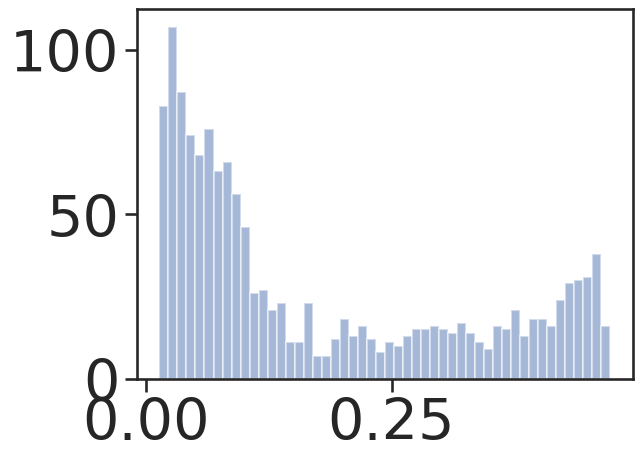

<IPython.core.display.Javascript object>

In [33]:
plt.hist(np.mean(0.5 * posterior_samples[:, :, 7], axis=0), bins=50, alpha=0.5)

In [34]:
posterior_samples.shape

(10000, 1406, 8)

<IPython.core.display.Javascript object>

In [35]:
np.save(ARTIFACT_PATH / "posterior_samples_bazaarvoice.npy", posterior_samples)

<IPython.core.display.Javascript object>

In [36]:
ARTIFACT_PATH

PosixPath('../../../gcs_mount/artifacts/rating_spacing_simulator')

<IPython.core.display.Javascript object>

# Use the inferred posterior samples to conduct simulations

In [15]:
posterior_samples = np.load(ARTIFACT_PATH / "posterior_samples_bazaarvoice.npy")
posterior_samples.shape

(10000, 1406, 8)

<IPython.core.display.Javascript object>

In [16]:
# Downsample the posterior samples so that we don't have to mmap a huge array when joblib parallelizes simulations
posterior_samples = posterior_samples[::5, :, :]
posterior_samples.shape

(2000, 1406, 8)

<IPython.core.display.Javascript object>

(array([10., 43., 64., 84., 80., 61., 49., 37., 38., 39., 31., 24., 32.,
        26., 26., 25., 12., 17., 15., 16., 14., 16., 15., 12., 12.,  7.,
        12.,  8., 10., 11., 11., 13., 15., 14., 25., 28., 23., 34., 16.,
        31., 37., 55., 57., 38., 37., 30., 31., 19., 34., 12.]),
 array([0.15363821, 0.21821389, 0.28278958, 0.34736526, 0.41194094,
        0.47651663, 0.54109231, 0.60566799, 0.67024367, 0.73481936,
        0.79939504, 0.86397072, 0.92854641, 0.99312209, 1.05769777,
        1.12227346, 1.18684914, 1.25142482, 1.31600051, 1.38057619,
        1.44515187, 1.50972755, 1.57430324, 1.63887892, 1.7034546 ,
        1.76803029, 1.83260597, 1.89718165, 1.96175734, 2.02633302,
        2.0909087 , 2.15548438, 2.22006007, 2.28463575, 2.34921143,
        2.41378712, 2.4783628 , 2.54293848, 2.60751417, 2.67208985,
        2.73666553, 2.80124121, 2.8658169 , 2.93039258, 2.99496826,
        3.05954395, 3.12411963, 3.18869531, 3.253271  , 3.31784668,
        3.38242236]),
 <BarContainer

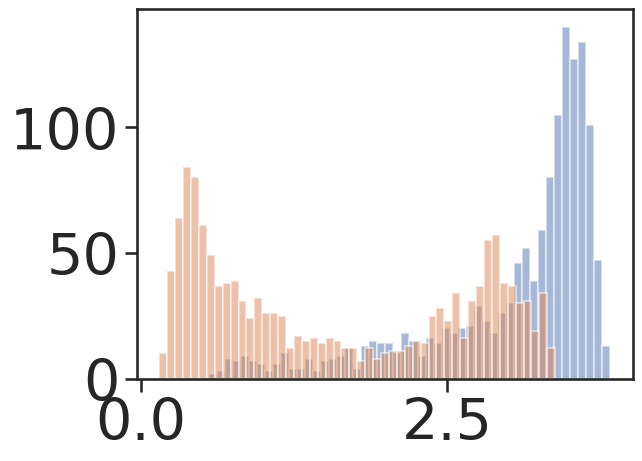

<IPython.core.display.Javascript object>

In [17]:
plt.hist(np.mean(posterior_samples[:, :, 0], axis=0), alpha=0.5, bins=50)
plt.hist(np.mean(posterior_samples[:, :, 1], axis=0), alpha=0.5, bins=50)

**Use the asin (same as productid) of the products to get the embeddings for these products
We will use the EmbeddingRatingPredictor class to get the embeddings merged on the DF of product reviews**


In [18]:
embedding_model = EmbeddingRatingPredictor(artifact_path=ARTIFACT_PATH)

	 Device set to cpu, using torch num threads=16
Using the dense network: 
 Sequential(
  (0): Linear(in_features=100, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=64, out_features=5, bias=True)
)


<IPython.core.display.Javascript object>

In [19]:
embedding_df = embedding_model.process_input_data()
embedding_df.head()

Merged product embeddings with review histograms and produced merged DF of shape: (13584, 8)


,productid,embedding,asin,1,2,3,4,5
0,2398095,"[0.00202922, 0.00146059, -0.00227462, -0.00132...",2398095,18,7,20,44,98
1,2457747,"[0.00181557, 0.00132517, -0.000414258, 0.00052...",2457747,12,4,6,23,48
2,2629881,"[0.00351794, 0.000763518, -0.00173591, 0.00375...",2629881,12,8,18,37,93
3,2621353,"[-0.00260368, 0.000267733, 0.000311891, 0.0001...",2621353,6,2,4,48,153
4,1222540,"[-0.00325687, -0.00082967, 0.000803526, -0.000...",1222540,15,4,6,27,147


<IPython.core.display.Javascript object>

In [20]:
# Check if all 1406 products for which we have posterior samples are in the embedding DF
assert pd.Series(timeseries_asin).isin(embedding_df.productid[:]).sum() == 1406

<IPython.core.display.Javascript object>

In [21]:
prod_embeddings = np.zeros(
    (timeseries_asin.shape[0], embedding_df["embedding"][0].shape[0]), dtype=np.float64
)

<IPython.core.display.Javascript object>

In [22]:
for i, asin in enumerate(timeseries_asin):
    prod_embeddings[i, :] = embedding_df["embedding"][
        np.where(embedding_df["asin"] == asin)[0][0]
    ]

<IPython.core.display.Javascript object>

In [23]:
# Check that all entries in prod_embeddings have been filled and no zeros remain
for i in range(prod_embeddings.shape[0]):
    np.testing.assert_raises(
        AssertionError,
        np.testing.assert_array_equal,
        prod_embeddings[i, :],
        np.zeros(prod_embeddings.shape[1]),
    )

<IPython.core.display.Javascript object>

In [24]:
prod_embeddings

array([[ 0.0417603 , -0.0184949 ,  0.0051865 , ...,  0.0144864 ,
         0.0513338 , -0.00083304],
       [-0.00676847, -0.0357962 , -0.0213361 , ...,  0.00515983,
        -0.0195145 ,  0.00069865],
       [ 0.00324716,  0.0094663 ,  0.00638726, ..., -0.00134284,
        -0.016803  , -0.0119215 ],
       ...,
       [ 0.0290542 ,  0.0164428 , -0.00513992, ..., -0.0171744 ,
         0.0152872 ,  0.0220019 ],
       [ 0.0101497 ,  0.00204149, -0.0213041 , ..., -0.0312605 ,
         0.0441172 ,  0.0134279 ],
       [-0.0409308 ,  0.02312   , -0.0420895 , ..., -0.0155858 ,
         0.00556547,  0.0107627 ]])

<IPython.core.display.Javascript object>

In [25]:
timeseries_data.shape

(1406,)

<IPython.core.display.Javascript object>

(array([715., 317., 129.,  76.,  48.,  43.,  14.,  20.,   7.,  37.]),
 array([  2. ,  53.9, 105.8, 157.7, 209.6, 261.5, 313.4, 365.3, 417.2,
        469.1, 521. ]),
 <BarContainer object of 10 artists>)

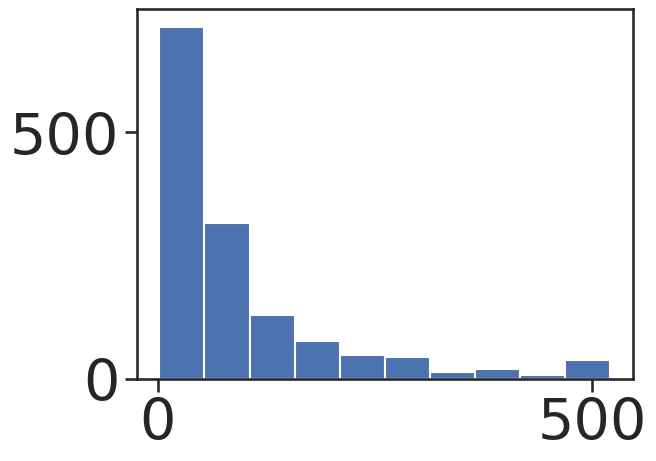

<IPython.core.display.Javascript object>

In [26]:
plt.hist([len(timeseries) for timeseries in timeseries_data])

**We will cut off the review timeseries for each product halfway. We will use the first half of each timeseries as input to the simulation process, and will try to predict the 2nd half through the simulations** 

In [27]:
timeseries_input = []
timeseries_half_len = np.zeros(len(timeseries_data), dtype=int)
for i, timeseries in enumerate(timeseries_data):
    timeseries_half_len[i] = len(timeseries) // 2
    timeseries_input.append(timeseries[: timeseries_half_len[i], :])

<IPython.core.display.Javascript object>

In [28]:
# Check that halving the timeseries has not resulted in zero ratings for any product
assert np.sum(timeseries_half_len == 0) == 0

<IPython.core.display.Javascript object>

In [29]:
pd.DataFrame(timeseries_half_len).describe()

,0
count,1406.000000
mean,46.716927
std,54.587364
min,1.000000
25%,13.000000
50%,26.000000
75%,57.000000
max,260.000000


<IPython.core.display.Javascript object>

In [30]:
timeseries_input = np.array(timeseries_input, dtype=object)

<IPython.core.display.Javascript object>

In [31]:
len(timeseries_input)

1406

<IPython.core.display.Javascript object>

In [32]:
np.sum(timeseries_half_len)

65684

<IPython.core.display.Javascript object>

In [33]:
# Create the dict of simulator parameters
simulator_params = {
    "review_prior": np.ones(5),
    "tendency_to_rate": 0.05,
    "simulation_type": "timeseries",
    "previous_rating_measure": "mode",
    "min_reviews_for_herding": 5,
    "num_products": posterior_samples.shape[1],
    # "num_products": 100,
    "num_total_marketplace_reviews": 140_000,
    # "num_total_marketplace_reviews": 10_000,
    "consideration_set_size": 5,
    "one_star_lowest_limit": -1.5,
    "five_star_highest_limit": 1.5,
    "max_bias_5_star": 0.5,
}
num_marketplaces = 32

<IPython.core.display.Javascript object>

In [34]:
# Sample from the posteriors to build a simulation parameter dict that we can use to input during simulations
# Since the posteriors were already sampled at random from the underlying normalizing flow, we can just
# directly use them
reshaped_posterior = np.tile(
    posterior_samples[:, None, :, :], (1, num_marketplaces, 1, 1)
).reshape(posterior_samples.shape[0], -1, 8)
reshaped_posterior.shape

(2000, 44992, 8)

<IPython.core.display.Javascript object>

In [37]:
for i in range(num_marketplaces):
    np.testing.assert_array_equal(
        reshaped_posterior[
            :, posterior_samples.shape[1] * i : posterior_samples.shape[1] * (i + 1), :
        ],
        posterior_samples[:, :, :],
    )
simulation_params = {
    "rho": reshaped_posterior[:, :, :2],
    "h_p": reshaped_posterior[:, :, 2],
    "p_1": reshaped_posterior[:, :, 3],
    "p_2": reshaped_posterior[:, :, 4],
    "p_4": reshaped_posterior[:, :, 5],
    "p_5": reshaped_posterior[:, :, 6],
    "bias_5_star": reshaped_posterior[:, :, 7],
}

<IPython.core.display.Javascript object>

In [40]:
simulator = marketplace_simulator_class.MarketplaceSimulator(simulator_params)

<IPython.core.display.Javascript object>

In [41]:
simulator.simulate(
    num_simulations=num_marketplaces,
    simulation_parameters=simulation_params,
    existing_reviews=timeseries_input,
    product_embeddings=prod_embeddings,
    embeddings_artifact_path=ARTIFACT_PATH,
)

Loaded product embedding density estimator: 
 GaussianMixture(max_iter=500, n_components=10, n_init=5, random_state=42,
                verbose=2, verbose_interval=20)
Loaded user embedding density estimator: 
 GaussianMixture(max_iter=500, n_components=10, n_init=5, random_state=42,
                verbose=2, verbose_interval=20)
	 Device set to cpu, using torch num threads=32
Using the dense network: 
 Sequential(
  (0): Linear(in_features=100, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=64, out_features=5, bias=True)
)
Loaded embedding -> rating predictor model: 
 RatingPredictorModel(
  (net): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_

Worker 1:   0%|          | 0/140000 [00:00<?, ?it/s]

Worker 2:   0%|          | 0/140000 [00:00<?, ?it/s]

Worker 3:   0%|          | 0/140000 [00:00<?, ?it/s]

Worker 4:   0%|          | 0/140000 [00:00<?, ?it/s]

Worker 5:   0%|          | 0/140000 [00:00<?, ?it/s]

Worker 6:   0%|          | 0/140000 [00:00<?, ?it/s]

Worker 7:   0%|          | 0/140000 [00:00<?, ?it/s]

Worker 8:   0%|          | 0/140000 [00:00<?, ?it/s]

Worker 9:   0%|          | 0/140000 [00:00<?, ?it/s]

Worker 10:   0%|          | 0/140000 [00:00<?, ?it/s]

Worker 11:   0%|          | 0/140000 [00:00<?, ?it/s]

Worker 12:   0%|          | 0/140000 [00:00<?, ?it/s]

Worker 13:   0%|          | 0/140000 [00:00<?, ?it/s]

Worker 14:   0%|          | 0/140000 [00:00<?, ?it/s]

Worker 15:   0%|          | 0/140000 [00:00<?, ?it/s]

Worker 16:   0%|          | 0/140000 [00:00<?, ?it/s]

Worker 17:   0%|          | 0/140000 [00:00<?, ?it/s]

Worker 18:   0%|          | 0/140000 [00:00<?, ?it/s]

Worker 19:   0%|          | 0/140000 [00:00<?, ?it/s]

Worker 20:   0%|          | 0/140000 [00:00<?, ?it/s]

Worker 21:   0%|          | 0/140000 [00:00<?, ?it/s]

Worker 22:   0%|          | 0/140000 [00:00<?, ?it/s]

Worker 23:   0%|          | 0/140000 [00:00<?, ?it/s]

Worker 24:   0%|          | 0/140000 [00:00<?, ?it/s]

Worker 25:   0%|          | 0/140000 [00:00<?, ?it/s]

Worker 26:   0%|          | 0/140000 [00:00<?, ?it/s]

Worker 27:   0%|          | 0/140000 [00:00<?, ?it/s]

Worker 28:   0%|          | 0/140000 [00:00<?, ?it/s]

Worker 29:   0%|          | 0/140000 [00:00<?, ?it/s]

Worker 30:   0%|          | 0/140000 [00:00<?, ?it/s]

Worker 31:   0%|          | 0/140000 [00:00<?, ?it/s]

Worker 32:   0%|          | 0/140000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [42]:
len(simulator.simulations)

32

<IPython.core.display.Javascript object>

In [43]:
simulator.save_simulations(ARTIFACT_PATH / "simulations_from_posterior")

<IPython.core.display.Javascript object>

In [44]:
np.save(
    ARTIFACT_PATH / "simulations_from_posterior" / "timeseries_input.npy",
    timeseries_input,
)
np.save(
    ARTIFACT_PATH / "simulations_from_posterior" / "timeseries_half_len",
    timeseries_half_len,
)

<IPython.core.display.Javascript object>

In [23]:
# Load the simulations that have already been run
simulator = marketplace_simulator_class.MarketplaceSimulator(simulator_params)
simulator.load_simulator(ARTIFACT_PATH / "simulations_from_posterior")

<IPython.core.display.Javascript object>

**Check the total number of reviews generated in the simulation**

In [45]:
num_reviews = np.array(
    [[len(product) for product in simulation] for simulation in simulator.simulations]
)

<IPython.core.display.Javascript object>

In [46]:
num_reviews.shape

(32, 1406)

<IPython.core.display.Javascript object>

In [47]:
np.sum(num_reviews, axis=1)

array([141406, 141406, 141406, 141406, 141406, 141406, 141406, 141406,
       141406, 141406, 141406, 141406, 141406, 141406, 141406, 141406,
       141406, 141406, 141406, 141406, 141406, 141406, 141406, 141406,
       141406, 141406, 141406, 141406, 141406, 141406, 141406, 141406])

<IPython.core.display.Javascript object>

**Run some tests to check that the simulations have been done correctly, i.e, the first half of the simulated reviews is the same as the input reviews and the 2nd half is different**

In [48]:
simulator.simulations.shape

(32, 1406)

<IPython.core.display.Javascript object>

In [51]:
for sim in range(simulator.simulations.shape[0]):
    for product in range(simulator.simulations.shape[1]):
        np.testing.assert_array_equal(
            simulator.simulations[sim, product][: timeseries_half_len[product]],
            timeseries_input[product],
        )

<IPython.core.display.Javascript object>

In [52]:
simulator.simulations[0, 1205][
    timeseries_half_len[1205] - 5 : timeseries_half_len[1205] + 2
]

array([[ 2.,  2.,  6., 36., 92.],
       [ 2.,  2.,  6., 36., 93.],
       [ 2.,  2.,  6., 36., 94.],
       [ 2.,  2.,  6., 36., 95.],
       [ 3.,  2.,  6., 36., 95.],
       [ 3.,  2.,  6., 37., 95.],
       [ 3.,  2.,  6., 38., 95.]])

<IPython.core.display.Javascript object>

In [53]:
timeseries_input[1205][-5:]

array([[ 2.,  2.,  6., 36., 92.],
       [ 2.,  2.,  6., 36., 93.],
       [ 2.,  2.,  6., 36., 94.],
       [ 2.,  2.,  6., 36., 95.],
       [ 3.,  2.,  6., 36., 95.]])

<IPython.core.display.Javascript object>

In [54]:
num_reviews = []
for sim in simulator.simulations:
    num_reviews += [len(prods) for prods in sim]
len(num_reviews)

44992

<IPython.core.display.Javascript object>

(array([1.501e+04, 8.372e+03, 3.866e+03, 3.935e+03, 3.802e+03, 2.739e+03,
        2.177e+03, 1.520e+03, 1.129e+03, 7.150e+02, 5.880e+02, 3.270e+02,
        2.420e+02, 1.600e+02, 1.800e+02, 1.640e+02, 3.400e+01, 4.000e+00,
        1.700e+01, 1.100e+01]),
 array([  1.  ,  33.15,  65.3 ,  97.45, 129.6 , 161.75, 193.9 , 226.05,
        258.2 , 290.35, 322.5 , 354.65, 386.8 , 418.95, 451.1 , 483.25,
        515.4 , 547.55, 579.7 , 611.85, 644.  ]),
 <BarContainer object of 20 artists>)

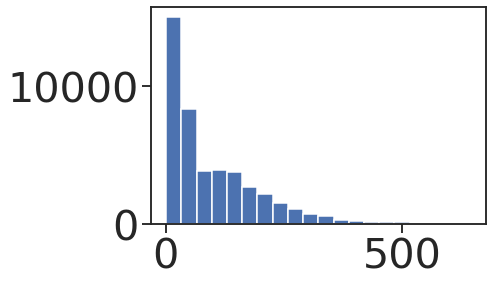

<IPython.core.display.Javascript object>

In [55]:
plt.hist(num_reviews, bins=20)

(array([23382.,  7801.,  6541.,  3697.,  1844.,   915.,   402.,   344.,
           38.,    28.]),
 array([  1. ,  65.3, 129.6, 193.9, 258.2, 322.5, 386.8, 451.1, 515.4,
        579.7, 644. ]),
 <BarContainer object of 10 artists>)

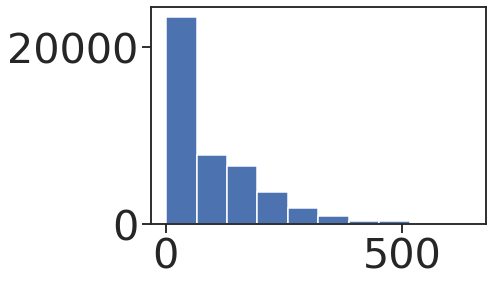

<IPython.core.display.Javascript object>

In [56]:
plt.hist(num_reviews)

In [57]:
pd.DataFrame({"num_reviews": num_reviews}).describe()

,num_reviews
count,44992.000000
mean,100.573257
std,97.963616
min,1.000000
25%,26.000000
50%,60.000000
75%,151.000000
max,644.000000


<IPython.core.display.Javascript object>

In [58]:
idx = np.array(
    [np.where(embedding_df["asin"] == asin)[0][0] for asin in timeseries_asin]
)
pd.DataFrame({"num_reviews": np.sum(embedding_df.iloc[idx, 3:], axis=1)}).describe()

,num_reviews
count,1406.000000
mean,96.212660
std,126.677148
min,1.000000
25%,25.250000
50%,51.000000
75%,113.000000
max,1293.000000


<IPython.core.display.Javascript object>

(array([811., 295., 118.,  60.,  49.,  16.,  19.,  13.,   9.,   6.,   1.,
          0.,   5.,   1.,   0.,   1.,   0.,   0.,   1.,   1.]),
 array([1.0000e+00, 6.5600e+01, 1.3020e+02, 1.9480e+02, 2.5940e+02,
        3.2400e+02, 3.8860e+02, 4.5320e+02, 5.1780e+02, 5.8240e+02,
        6.4700e+02, 7.1160e+02, 7.7620e+02, 8.4080e+02, 9.0540e+02,
        9.7000e+02, 1.0346e+03, 1.0992e+03, 1.1638e+03, 1.2284e+03,
        1.2930e+03]),
 <BarContainer object of 20 artists>)

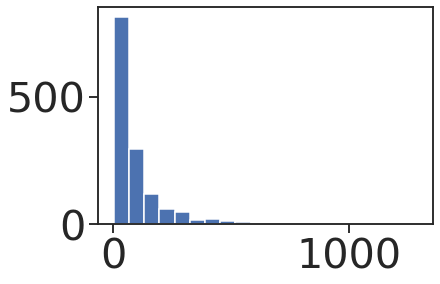

<IPython.core.display.Javascript object>

In [59]:
plt.hist(np.sum(embedding_df.iloc[idx, 3:], axis=1), bins=20)

In [60]:
pd.DataFrame({"num_reviews": num_reviews}).describe()

,num_reviews
count,44992.000000
mean,100.573257
std,97.963616
min,1.000000
25%,26.000000
50%,60.000000
75%,151.000000
max,644.000000


<IPython.core.display.Javascript object>

In [61]:
ratings = np.zeros(5)
for sim in simulator.simulations:
    for prods in sim:
        ratings += prods[-1]

<IPython.core.display.Javascript object>

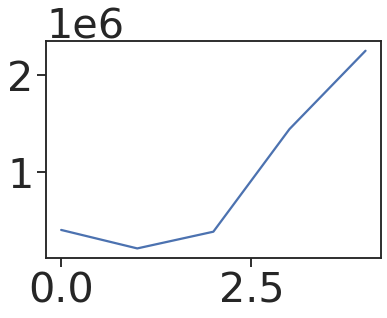

<IPython.core.display.Javascript object>

In [62]:
plt.plot(np.arange(5), ratings)

In [63]:
index = []
for sim in simulator.simulations:
    for prods in sim:
        diff = np.sum(prods[-1][3:]) - np.sum(prods[-1][:2])
        index.append(diff)

<IPython.core.display.Javascript object>

(array([ 9650., 16067.,  6269.,  6430.,  3185.,  1635.,   972.,   554.,
          181.,    49.]),
 array([-34. ,  10.5,  55. ,  99.5, 144. , 188.5, 233. , 277.5, 322. ,
        366.5, 411. ]),
 <BarContainer object of 10 artists>)

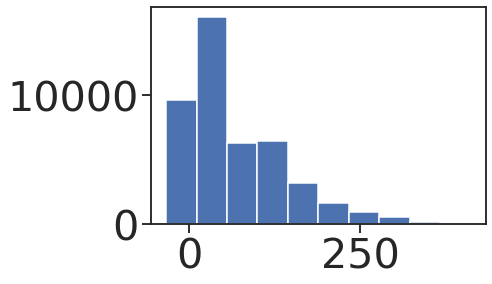

<IPython.core.display.Javascript object>

In [64]:
plt.hist(index)

In [65]:
print(np.mean(np.array(index) >= 0))

0.9787295519203414


<IPython.core.display.Javascript object>

In [66]:
embedding_df.head()

,productid,embedding,asin,1,2,3,4,5
0,2398095,"[0.00202922, 0.00146059, -0.00227462, -0.00132...",2398095,18,7,20,44,98
1,2457747,"[0.00181557, 0.00132517, -0.000414258, 0.00052...",2457747,12,4,6,23,48
2,2629881,"[0.00351794, 0.000763518, -0.00173591, 0.00375...",2629881,12,8,18,37,93
3,2621353,"[-0.00260368, 0.000267733, 0.000311891, 0.0001...",2621353,6,2,4,48,153
4,1222540,"[-0.00325687, -0.00082967, 0.000803526, -0.000...",1222540,15,4,6,27,147


<IPython.core.display.Javascript object>

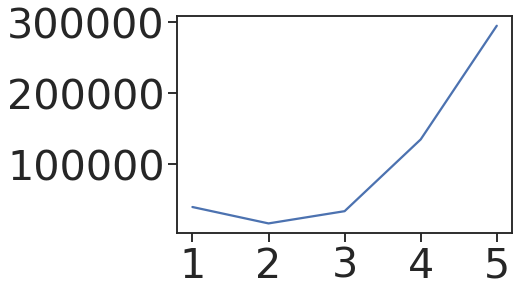

<IPython.core.display.Javascript object>

In [67]:
plt.plot(np.sum(embedding_df.iloc[:, 3:], axis=0))

**We will try to compare the final histograms for a few products with those in the real data**

In [68]:
idx = np.where(embedding_df["asin"] == timeseries_asin[0])[0][0]
idx

1900

<IPython.core.display.Javascript object>

In [69]:
embedding_df.iloc[1760, :]

productid                                              4232173
embedding    [0.0130474, -0.00801388, -0.0083162, 0.0044740...
asin                                                   4232173
1                                                            9
2                                                            4
3                                                            9
4                                                           68
5                                                          133
Name: 1760, dtype: object

<IPython.core.display.Javascript object>

In [70]:
sims = []
for sim in simulator.simulations:
    sims.append(sim[0][-1])

<IPython.core.display.Javascript object>

In [54]:
sims = np.array(sims)
sims /= np.sum(sims, axis=1)[:, None]

<IPython.core.display.Javascript object>

In [55]:
sims

array([[0.18363273, 0.10379242, 0.1237525 , 0.23952096, 0.3493014 ],
       [0.16816143, 0.09865471, 0.10538117, 0.31838565, 0.30941704],
       [0.18997912, 0.09812109, 0.07933194, 0.31524008, 0.31732777],
       [0.16666667, 0.09670782, 0.1255144 , 0.29218107, 0.31893004],
       [0.18979592, 0.08571429, 0.10204082, 0.27755102, 0.34489796],
       [0.18548387, 0.09274194, 0.12096774, 0.26612903, 0.33467742],
       [0.18942731, 0.09251101, 0.11013216, 0.27753304, 0.33039648],
       [0.18103448, 0.09482759, 0.11637931, 0.32543103, 0.28232759],
       [0.17634855, 0.10580913, 0.12240664, 0.24688797, 0.34854772],
       [0.18585859, 0.09494949, 0.10909091, 0.28282828, 0.32727273],
       [0.19650655, 0.10262009, 0.10480349, 0.22052402, 0.37554585],
       [0.18502203, 0.10132159, 0.12334802, 0.24008811, 0.35022026],
       [0.18811881, 0.1009901 , 0.08910891, 0.26336634, 0.35841584],
       [0.17269076, 0.1064257 , 0.09437751, 0.33333333, 0.29317269],
       [0.16363636, 0.10505051, 0.

<IPython.core.display.Javascript object>

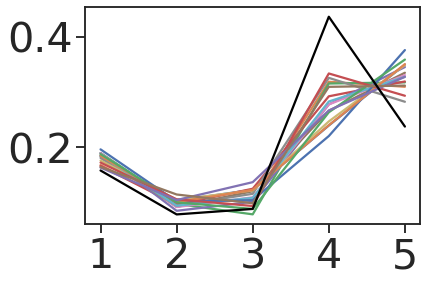

<IPython.core.display.Javascript object>

In [58]:
plt.plot(sims.T)
plt.plot(
    embedding_df.iloc[1760, 3:] / np.sum(embedding_df.iloc[1760, 3:]), color="black"
)

In [68]:
idx = np.where(embedding_df["asin"] == timeseries_asin[1000])[0][0]
idx

3722

<IPython.core.display.Javascript object>

In [69]:
embedding_df.iloc[3722, :]

productid                                              6247836
embedding    [-0.0526099, 0.0766598, 0.00164629, -0.0169849...
asin                                                   6247836
1                                                            3
2                                                            2
3                                                            2
4                                                            6
5                                                           19
Name: 3722, dtype: object

<IPython.core.display.Javascript object>

In [70]:
sims = []
for sim in simulator.simulations:
    sims.append(sim[1000][-1])

<IPython.core.display.Javascript object>

In [71]:
sims = np.array(sims)
sims /= np.sum(sims, axis=1)[:, None]

<IPython.core.display.Javascript object>

In [72]:
sims

array([[0.10526316, 0.05263158, 0.1754386 , 0.22807018, 0.43859649],
       [0.14285714, 0.05194805, 0.12987013, 0.28571429, 0.38961039],
       [0.06666667, 0.11666667, 0.06666667, 0.38333333, 0.36666667],
       [0.13114754, 0.06557377, 0.13114754, 0.18032787, 0.49180328],
       [0.09230769, 0.09230769, 0.15384615, 0.21538462, 0.44615385],
       [0.12962963, 0.05555556, 0.14814815, 0.2962963 , 0.37037037],
       [0.12068966, 0.06896552, 0.15517241, 0.22413793, 0.43103448],
       [0.09259259, 0.07407407, 0.09259259, 0.27777778, 0.46296296],
       [0.11764706, 0.05882353, 0.17647059, 0.22058824, 0.42647059],
       [0.1       , 0.1       , 0.16666667, 0.18333333, 0.45      ],
       [0.09677419, 0.06451613, 0.17741935, 0.22580645, 0.43548387],
       [0.10344828, 0.06896552, 0.17241379, 0.20689655, 0.44827586],
       [0.14285714, 0.05357143, 0.16071429, 0.17857143, 0.46428571],
       [0.13888889, 0.05555556, 0.09722222, 0.26388889, 0.44444444],
       [0.12857143, 0.07142857, 0.

<IPython.core.display.Javascript object>

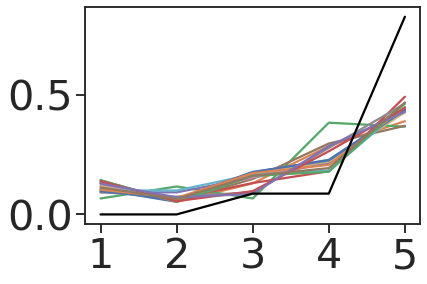

<IPython.core.display.Javascript object>

In [73]:
plt.plot(sims.T)
plt.plot(
    embedding_df.iloc[5048, 3:] / np.sum(embedding_df.iloc[5048, 3:]), color="black"
)

In [88]:
timeseries_data[1].shape

(4, 5)

<IPython.core.display.Javascript object>

In [83]:
simulator.simulations[15][0].shape

(439, 5)

<IPython.core.display.Javascript object>

In [110]:
# This checks the review-by-review accuracy for the first t reviews for each product
# Accuracy is reported as the % of simulations that produced the exact same star rating
accuracy = []
for i in range(timeseries_data.shape[0]):
    this_prod_accuracy = []
    for t in range(1, 15, 1):
        correct = 0
        for j in range(len(simulator.simulations)):
            try:
                correct += int(
                    np.array_equal(
                        timeseries_data[i][t, :], simulator.simulations[j][i][t, :]
                    )
                )
            except:
                correct = np.nan
                continue
        this_prod_accuracy.append(correct / len(simulator.simulations))
    accuracy.append(this_prod_accuracy)

<IPython.core.display.Javascript object>

In [135]:
# This is a different measure of accuracy - we first take the predicted rating to be the most common rating
# produced by the simulations. Then we check if the real rating is the same as this most common rating
# We measure accuracy as the absolute difference between the real and predicted rating
accuracy = []
for i in range(timeseries_data.shape[0]):
    this_prod_accuracy = []
    for t in range(1, 50, 1):
        ratings = []
        for j in range(len(simulator.simulations)):
            try:
                rating = (
                    np.where(
                        simulator.simulations[j][i][t, :]
                        - simulator.simulations[j][i][t - 1, :]
                    )[0][0]
                    + 1
                )
            except:
                rating = np.nan
            ratings.append(rating)
        ratings = np.array(ratings)

        try:
            pred_rating = np.argmax(np.bincount(ratings[~np.isnan(ratings)]))
            obs_rating = (
                np.where(timeseries_data[i][t, :] - timeseries_data[i][t - 1, :])[0][0]
                + 1
            )
        except:
            obs_rating = np.nan
            pred_rating = np.nan
        this_prod_accuracy.append(np.abs(pred_rating - obs_rating))
    accuracy.append(this_prod_accuracy)

<IPython.core.display.Javascript object>

In [147]:
# Another different measure of accuracy - here we take the most common rating as the predicted rating as before
# But just calculate the accuracy, across products - i.e, for how many products is this predicted rating the same
# as the observed rating
accuracy = []
for i in range(timeseries_data.shape[0]):
    this_prod_accuracy = []
    for t in range(1, 20, 1):
        ratings = []
        for j in range(len(simulator.simulations)):
            try:
                rating = (
                    np.where(
                        simulator.simulations[j][i][t, :]
                        - simulator.simulations[j][i][t - 1, :]
                    )[0][0]
                    + 1
                )
            except:
                rating = np.nan
            ratings.append(rating)
        ratings = np.array(ratings)

        try:
            pred_rating = np.argmax(np.bincount(ratings[~np.isnan(ratings)]))
            obs_rating = (
                np.where(timeseries_data[i][t, :] - timeseries_data[i][t - 1, :])[0][0]
                + 1
            )
            this_prod_accuracy.append(pred_rating == obs_rating)
        except:
            obs_rating = np.nan
            pred_rating = np.nan
            this_prod_accuracy.append(np.nan)
    accuracy.append(this_prod_accuracy)

<IPython.core.display.Javascript object>

In [148]:
accuracy = np.array(accuracy)
accuracy

array([[ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  1.,  1., ...,  0.,  0.,  1.],
       ...,
       [ 0.,  1.,  0., ...,  0.,  0.,  1.],
       [ 0.,  1.,  0., ...,  1.,  0.,  1.],
       [ 1.,  1.,  1., ...,  0.,  0.,  0.]])

<IPython.core.display.Javascript object>

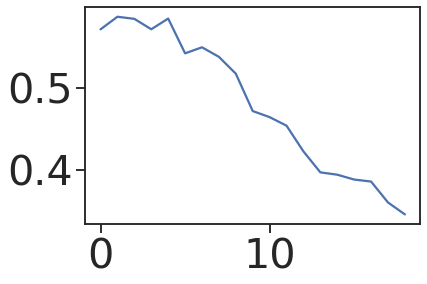

<IPython.core.display.Javascript object>

In [149]:
plt.plot(np.nanmean(accuracy[:, :], axis=0))

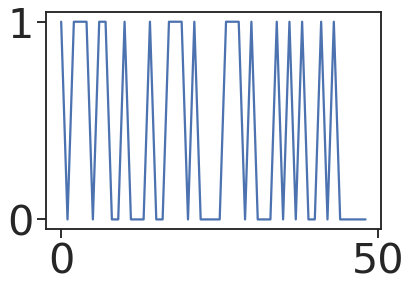

<IPython.core.display.Javascript object>

In [146]:
plt.plot(accuracy[78, :])

**Will need to use multinomial distributions to see what the baseline probability for such events will be assuming a random classifier - one that produces 1-5 star with equal probability**

**Next we will design a similar set of accuracy tests for simulations that used existing reviews**

**First check how the reviews for a specific product look**

In [92]:
idx = np.where(embedding_df["asin"] == timeseries_asin[45])[0][0]
idx

3126

<IPython.core.display.Javascript object>

In [93]:
embedding_df.iloc[3126, :]

productid                                              1068388
embedding    [0.0177991, -0.0077902, -0.0126334, 0.00898823...
asin                                                   1068388
1                                                           62
2                                                           13
3                                                           17
4                                                           48
5                                                           95
Name: 3126, dtype: object

<IPython.core.display.Javascript object>

In [94]:
sims = []
for sim in simulator.simulations:
    sims.append(sim[45][-1] - sim[45][timeseries_half_len[45]])

<IPython.core.display.Javascript object>

In [95]:
sims = np.array(sims)
sims /= np.sum(sims, axis=1)[:, None]

<IPython.core.display.Javascript object>

In [96]:
sims

array([[0.23863636, 0.03409091, 0.02272727, 0.13636364, 0.56818182],
       [0.24637681, 0.02898551, 0.08695652, 0.07246377, 0.56521739],
       [0.17721519, 0.05063291, 0.10126582, 0.05063291, 0.62025316],
       [0.31168831, 0.        , 0.09090909, 0.03896104, 0.55844156],
       [0.28235294, 0.01176471, 0.11764706, 0.01176471, 0.57647059],
       [0.22535211, 0.02816901, 0.11267606, 0.14084507, 0.49295775],
       [0.23076923, 0.03296703, 0.07692308, 0.14285714, 0.51648352],
       [0.18644068, 0.01694915, 0.11864407, 0.11864407, 0.55932203],
       [0.1954023 , 0.04597701, 0.08045977, 0.10344828, 0.57471264],
       [0.27272727, 0.03409091, 0.125     , 0.02272727, 0.54545455],
       [0.17105263, 0.02631579, 0.05263158, 0.21052632, 0.53947368],
       [0.22727273, 0.02272727, 0.05681818, 0.10227273, 0.59090909],
       [0.22352941, 0.03529412, 0.09411765, 0.11764706, 0.52941176],
       [0.16049383, 0.03703704, 0.13580247, 0.11111111, 0.55555556],
       [0.20731707, 0.        , 0.

<IPython.core.display.Javascript object>

([<matplotlib.axis.XTick at 0x7f45773f8400>,
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5')])

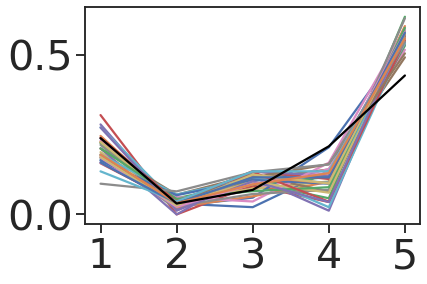

<IPython.core.display.Javascript object>

In [97]:
plt.plot(sims.T)
real_data = timeseries_data[45][-1] - timeseries_data[45][timeseries_half_len[45]]
plt.plot(real_data / np.sum(real_data), color="black")
plt.xticks([0, 1, 2, 3, 4], labels=["1", "2", "3", "4", "5"])

In [98]:
idx = np.where(embedding_df["asin"] == timeseries_asin[1000])[0][0]
idx

4202

<IPython.core.display.Javascript object>

In [99]:
embedding_df.iloc[4202, :]

productid                                              6247836
embedding    [0.00325097, -0.0225528, -0.000740233, -0.0006...
asin                                                   6247836
1                                                            3
2                                                            2
3                                                            2
4                                                            6
5                                                           19
Name: 4202, dtype: object

<IPython.core.display.Javascript object>

In [100]:
sims = []
for sim in simulator.simulations:
    sims.append(sim[1000][-1] - sim[1000][timeseries_half_len[1000]])

<IPython.core.display.Javascript object>

In [101]:
sims = np.array(sims)
sims /= np.sum(sims, axis=1)[:, None]

<IPython.core.display.Javascript object>

In [102]:
sims

array([[0.125     , 0.0625    , 0.1875    , 0.25      , 0.375     ],
       [0.05263158, 0.05263158, 0.26315789, 0.15789474, 0.47368421],
       [0.28      , 0.        , 0.04      , 0.08      , 0.6       ],
       [0.23529412, 0.        , 0.05882353, 0.11764706, 0.58823529],
       [0.04545455, 0.13636364, 0.31818182, 0.09090909, 0.40909091],
       [0.18181818, 0.09090909, 0.09090909, 0.09090909, 0.54545455],
       [0.15789474, 0.05263158, 0.10526316, 0.05263158, 0.63157895],
       [0.1       , 0.1       , 0.2       , 0.1       , 0.5       ],
       [0.0625    , 0.1875    , 0.125     , 0.1875    , 0.4375    ],
       [0.17647059, 0.05882353, 0.05882353, 0.11764706, 0.58823529],
       [0.2       , 0.08      , 0.04      , 0.08      , 0.6       ],
       [0.        , 0.        , 0.125     , 0.375     , 0.5       ],
       [0.        , 0.        , 0.2       , 0.4       , 0.4       ],
       [0.08333333, 0.        , 0.25      , 0.        , 0.66666667],
       [0.06666667, 0.        , 0.

<IPython.core.display.Javascript object>

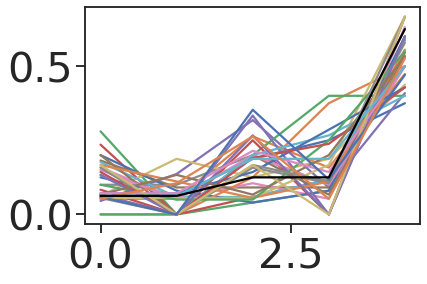

<IPython.core.display.Javascript object>

In [103]:
plt.plot(sims.T)
real_data = timeseries_data[1000][-1] - timeseries_data[1000][timeseries_half_len[1000]]
plt.plot(real_data / np.sum(real_data), color="black")

In [104]:
timeseries_data[1].shape

(4, 5)

<IPython.core.display.Javascript object>

In [105]:
simulator.simulations[15][1].shape

(14, 5)

<IPython.core.display.Javascript object>

In [106]:
# This checks the review-by-review accuracy for the first t reviews (after the existing/input reviews)
# for each product
# Accuracy is reported as the % of simulations that produced the exact same star rating
accuracy = []
for i in range(timeseries_data.shape[0]):
    this_prod_accuracy = []
    for t in range(timeseries_half_len[i] + 1, timeseries_half_len[i] + 15, 1):
        correct = 0
        for j in range(len(simulator.simulations)):
            try:
                correct += int(
                    np.array_equal(
                        timeseries_data[i][t, :], simulator.simulations[j][i][t, :]
                    )
                )
            except:
                correct = np.nan
                continue
        this_prod_accuracy.append(correct / len(simulator.simulations))
    accuracy.append(this_prod_accuracy)

<IPython.core.display.Javascript object>

In [113]:
# This is a different measure of accuracy - we first take the predicted rating to be the most common rating
# produced by the simulations. Then we check if the real rating is the same as this most common rating
# We measure accuracy as the absolute difference between the real and predicted rating
accuracy = []
for i in range(timeseries_data.shape[0]):
    this_prod_accuracy = []
    for t in range(timeseries_half_len[i] + 1, timeseries_half_len[i] + 25, 1):
        ratings = []
        for j in range(len(simulator.simulations)):
            try:
                rating = (
                    np.where(
                        simulator.simulations[j][i][t, :]
                        - simulator.simulations[j][i][t - 1, :]
                    )[0][0]
                    + 1
                )
            except:
                rating = np.nan
            ratings.append(rating)
        ratings = np.array(ratings)

        try:
            pred_rating = np.argmax(np.bincount(ratings[~np.isnan(ratings)]))
            obs_rating = (
                np.where(timeseries_data[i][t, :] - timeseries_data[i][t - 1, :])[0][0]
                + 1
            )
        except:
            obs_rating = np.nan
            pred_rating = np.nan
        this_prod_accuracy.append(np.abs(pred_rating - obs_rating))
    accuracy.append(this_prod_accuracy)

<IPython.core.display.Javascript object>

In [122]:
# This is a different measure of accuracy
# We measure accuracy as the absolute difference between the real and predicted rating
# We average this absolute difference across multiple simulations, instead of taking the most common predicted
# rating first
accuracy = []
for i in range(timeseries_data.shape[0]):
    this_prod_accuracy = []
    for t in range(timeseries_half_len[i] + 1, timeseries_half_len[i] + 50, 1):
        ratings = []
        for j in range(len(simulator.simulations)):
            try:
                rating = (
                    np.where(
                        simulator.simulations[j][i][t, :]
                        - simulator.simulations[j][i][t - 1, :]
                    )[0][0]
                    + 1
                )
            except:
                rating = np.nan
            ratings.append(rating)
        ratings = np.array(ratings)

        try:
            obs_rating = (
                np.where(timeseries_data[i][t, :] - timeseries_data[i][t - 1, :])[0][0]
                + 1
            )
            diff = np.nanmean(np.abs(ratings - obs_rating))
        except:
            diff = np.nan
        this_prod_accuracy.append(diff)
    accuracy.append(this_prod_accuracy)

/tmp/ipykernel_331/4006397458.py:29: RuntimeWarning: Mean of empty slice
  diff = np.nanmean(np.abs(ratings - obs_rating))


<IPython.core.display.Javascript object>

In [119]:
# Another different measure of accuracy - here we take the most common rating as the predicted rating as before
# But just calculate the accuracy, across products - i.e, for how many products is this predicted rating the same
# as the observed rating
accuracy = []
for i in range(timeseries_data.shape[0]):
    this_prod_accuracy = []
    for t in range(timeseries_half_len[i] + 1, timeseries_half_len[i] + 20, 1):
        ratings = []
        for j in range(len(simulator.simulations)):
            try:
                rating = (
                    np.where(
                        simulator.simulations[j][i][t, :]
                        - simulator.simulations[j][i][t - 1, :]
                    )[0][0]
                    + 1
                )
            except:
                rating = np.nan
            ratings.append(rating)
        ratings = np.array(ratings)

        try:
            pred_rating = np.argmax(np.bincount(ratings[~np.isnan(ratings)]))
            obs_rating = (
                np.where(timeseries_data[i][t, :] - timeseries_data[i][t - 1, :])[0][0]
                + 1
            )
            this_prod_accuracy.append(pred_rating == obs_rating)
        except:
            obs_rating = np.nan
            pred_rating = np.nan
            this_prod_accuracy.append(np.nan)
    accuracy.append(this_prod_accuracy)

<IPython.core.display.Javascript object>

In [123]:
accuracy = np.array(accuracy)
accuracy

array([[1.1875 , 1.1875 , 0.96875, ..., 2.     , 2.5    , 1.9375 ],
       [1.25   ,     nan,     nan, ...,     nan,     nan,     nan],
       [1.21875, 1.25   , 0.65625, ..., 0.625  , 3.21875, 0.9375 ],
       ...,
       [2.21875, 2.53125, 1.875  , ..., 1.34375, 1.46875, 1.40625],
       [0.96875, 1.125  , 1.09375, ..., 0.9375 , 3.     , 0.75   ],
       [1.0625 , 0.90625, 0.5625 , ..., 0.71875, 0.96875, 3.25   ]])

<IPython.core.display.Javascript object>

<ErrorbarContainer object of 3 artists>

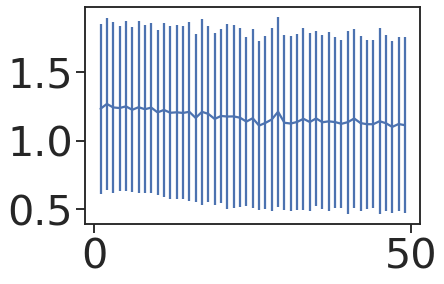

<IPython.core.display.Javascript object>

In [124]:
plt.errorbar(
    np.arange(49) + 1, np.nanmean(accuracy, axis=0), np.nanstd(accuracy, axis=0)
)

In [125]:
accuracy.shape

(1406, 49)

<IPython.core.display.Javascript object>

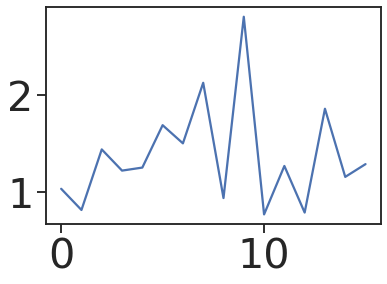

<IPython.core.display.Javascript object>

In [126]:
plt.plot(accuracy[1000, :])

In [127]:
accuracy[1000, :]

array([1.03125   , 0.8125    , 1.4375    , 1.21875   , 1.25      ,
       1.6875    , 1.5       , 2.125     , 0.93548387, 2.80645161,
       0.76666667, 1.26666667, 0.78571429, 1.85714286, 1.15384615,
       1.28571429,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan])

<IPython.core.display.Javascript object>

**We can also calculate a (moving) average rating of the simulated reviews and compare to the actual**

In [128]:
real_avg_rating = []
sim_avg_rating = []
for product in range(timeseries_data.shape[0]):
    real_rating = (
        timeseries_data[product][timeseries_half_len[product] :]
        - timeseries_data[product][timeseries_half_len[product] - 1][None, :]
    )
    real_avg_rating.append(
        np.sum(
            (real_rating / np.sum(real_rating, axis=1)[:, None]) * np.arange(1, 6),
            axis=1,
        )
    )
    this_prod_avg_rating = []
    for sim in range(simulator.simulations.shape[0]):
        sim_rating = (
            simulator.simulations[sim, product][
                timeseries_half_len[product] : timeseries_data[product].shape[0]
            ]
            - simulator.simulations[sim, product][timeseries_half_len[product] - 1][
                None, :
            ]
        )
        this_prod_avg_rating.append(
            np.sum(
                (sim_rating / np.sum(sim_rating, axis=1)[:, None]) * np.arange(1, 6),
                axis=1,
            )
        )
    sim_avg_rating.append(this_prod_avg_rating)

<IPython.core.display.Javascript object>

In [129]:
real_avg_rating = np.array(real_avg_rating)
sim_avg_rating = np.array(sim_avg_rating)
real_avg_rating.shape, sim_avg_rating.shape

/tmp/ipykernel_331/3557943907.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  real_avg_rating = np.array(real_avg_rating)
/tmp/ipykernel_331/3557943907.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sim_avg_rating = np.array(sim_avg_rating)


((1406,), (1406, 32))

<IPython.core.display.Javascript object>

In [130]:
# As the simulations run independently, it could be possible that some of the simulations do not accumulate
# the same number of reviews as the real product. So we cut both the real and simulated time series to the
# smallest length where they both have data
for i in range(real_avg_rating.shape[0]):
    min_sim_len = np.min([len(sim) for sim in sim_avg_rating[i, :]])
    real_len = len(real_avg_rating[i])
    cut_len = min(min_sim_len, real_len)
    real_avg_rating[i] = real_avg_rating[i][:cut_len]
    for j in range(sim_avg_rating.shape[1]):
        sim_avg_rating[i, j] = sim_avg_rating[i, j][:cut_len]

<IPython.core.display.Javascript object>

In [131]:
np.array([len(sim) for sim in sim_avg_rating[2, :]])

array([88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88,
       88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88])

<IPython.core.display.Javascript object>

In [132]:
len(real_avg_rating[2])

88

<IPython.core.display.Javascript object>

In [133]:
real_avg_rating[2]

array([1.        , 3.        , 3.66666667, 4.        , 3.8       ,
       4.        , 4.14285714, 4.25      , 4.22222222, 4.3       ,
       4.36363636, 4.41666667, 4.46153846, 4.5       , 4.53333333,
       4.5625    , 4.58823529, 4.61111111, 4.63157895, 4.65      ,
       4.66666667, 4.68181818, 4.69565217, 4.70833333, 4.68      ,
       4.65384615, 4.66666667, 4.53571429, 4.55172414, 4.5       ,
       4.51612903, 4.53125   , 4.54545455, 4.44117647, 4.34285714,
       4.36111111, 4.37837838, 4.36842105, 4.38461538, 4.35      ,
       4.36585366, 4.35714286, 4.37209302, 4.38636364, 4.4       ,
       4.39130435, 4.36170213, 4.375     , 4.30612245, 4.3       ,
       4.31372549, 4.28846154, 4.30188679, 4.24074074, 4.25454545,
       4.26785714, 4.21052632, 4.22413793, 4.16949153, 4.18333333,
       4.13114754, 4.14516129, 4.0952381 , 4.109375  , 4.10769231,
       4.10606061, 4.10447761, 4.10294118, 4.11594203, 4.1       ,
       4.08450704, 4.09722222, 4.08219178, 4.09459459, 4.05333

<IPython.core.display.Javascript object>

<ErrorbarContainer object of 3 artists>

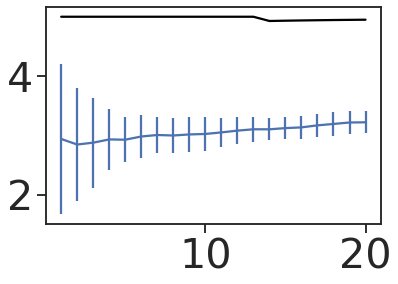

<IPython.core.display.Javascript object>

In [147]:
product = 875
plt.plot(
    np.arange(real_avg_rating[product].shape[0]) + 1,
    real_avg_rating[product],
    color="black",
)
sim_arr = np.array([sim for sim in sim_avg_rating[product]])
plt.errorbar(
    np.arange(real_avg_rating[product].shape[0]) + 1,
    np.mean(sim_arr, axis=0),
    np.std(sim_arr, axis=0),
)

In [138]:
timeseries_data[875][timeseries_half_len[875] :] - timeseries_data[875][
    timeseries_half_len[875] - 1
]

array([[  0.,   0.,   0.,   0.,   1.],
       [  0.,   0.,   0.,   0.,   2.],
       [  0.,   0.,   0.,   0.,   3.],
       [  0.,   0.,   0.,   0.,   4.],
       [  0.,   0.,   0.,   0.,   5.],
       [  0.,   0.,   0.,   0.,   6.],
       [  0.,   0.,   0.,   0.,   7.],
       [  0.,   0.,   0.,   0.,   8.],
       [  0.,   0.,   0.,   0.,   9.],
       [  0.,   0.,   0.,   0.,  10.],
       [  0.,   0.,   0.,   0.,  11.],
       [  0.,   0.,   0.,   0.,  12.],
       [  0.,   0.,   0.,   0.,  13.],
       [  0.,   0.,   0.,   1.,  13.],
       [  0.,   0.,   0.,   1.,  14.],
       [  0.,   0.,   0.,   1.,  15.],
       [  0.,   0.,   0.,   1.,  16.],
       [  0.,   0.,   0.,   1.,  17.],
       [  0.,   0.,   0.,   1.,  18.],
       [  0.,   0.,   0.,   1.,  19.],
       [  0.,   0.,   0.,   1.,  20.],
       [  0.,   0.,   0.,   1.,  21.],
       [  0.,   0.,   0.,   1.,  22.],
       [  0.,   0.,   0.,   1.,  23.],
       [  0.,   0.,   0.,   1.,  24.],
       [  0.,   0.,   0.,

<IPython.core.display.Javascript object>

In [139]:
simulator.simulations[10, 875][timeseries_half_len[875] :] - simulator.simulations[
    10, 875
][timeseries_half_len[875] - 1]

array([[ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  2.,  0.],
       [ 0.,  0.,  1.,  2.,  0.],
       [ 0.,  0.,  1.,  3.,  0.],
       [ 1.,  0.,  1.,  3.,  0.],
       [ 1.,  0.,  1.,  4.,  0.],
       [ 1.,  0.,  1.,  5.,  0.],
       [ 2.,  0.,  1.,  5.,  0.],
       [ 2.,  0.,  2.,  5.,  0.],
       [ 2.,  0.,  3.,  5.,  0.],
       [ 2.,  0.,  3.,  6.,  0.],
       [ 3.,  0.,  3.,  6.,  0.],
       [ 3.,  0.,  3.,  7.,  0.],
       [ 3.,  0.,  3.,  8.,  0.],
       [ 4.,  0.,  3.,  8.,  0.],
       [ 4.,  0.,  3.,  9.,  0.],
       [ 4.,  0.,  3., 10.,  0.],
       [ 4.,  0.,  3., 11.,  0.],
       [ 4.,  1.,  3., 11.,  0.],
       [ 4.,  1.,  3., 12.,  0.],
       [ 4.,  1.,  3., 12.,  1.],
       [ 4.,  1.,  3., 13.,  1.],
       [ 4.,  1.,  3., 14.,  1.],
       [ 4.,  1.,  3., 15.,  1.],
       [ 4.,  1.,  3., 16.,  1.]])

<IPython.core.display.Javascript object>

In [140]:
max_review_len = max([len(prod) for prod in real_avg_rating])
prod_avg_real_rating = np.full((real_avg_rating.shape[0], max_review_len), np.nan)
prod_avg_sim_rating = np.full((real_avg_rating.shape[0], max_review_len), np.nan)
for prod in range(real_avg_rating.shape[0]):
    prod_avg_real_rating[prod, : len(real_avg_rating[prod])] = real_avg_rating[prod]
    sim_array = np.array([sim for sim in sim_avg_rating[prod]])
    prod_avg_sim_rating[prod, : len(real_avg_rating[prod])] = np.mean(sim_array, axis=0)

<IPython.core.display.Javascript object>

In [141]:
prod_avg_real_rating.shape, prod_avg_sim_rating.shape

((1406, 239), (1406, 239))

<IPython.core.display.Javascript object>

<ErrorbarContainer object of 3 artists>

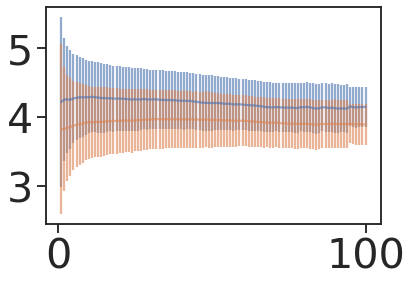

<IPython.core.display.Javascript object>

In [142]:
plt.errorbar(
    np.arange(100) + 1,
    np.nanmean(prod_avg_real_rating[:, :100], axis=0),
    np.nanstd(prod_avg_real_rating[:, :100], axis=0),
    alpha=0.6,
)
plt.errorbar(
    np.arange(100) + 1,
    np.nanmean(prod_avg_sim_rating[:, :100], axis=0),
    np.nanstd(prod_avg_real_rating[:, :100], axis=0),
    alpha=0.6,
)

# Creating a baseline for the review timeseries prediction task using a simple categorical model

In order to have a baseline comparison for review prediction using the simulation model (and any other timeseries prediction methods like RNN later), we will use predictions from a categorical probability distribution. The probabilities of this categorical distribution can be the 50% (half-way) review histogram that we already have - using these reviews from the first half of the timeseries for each product, we will try to predict the 2nd half 

In [ ]:
real_avg_rating = []
sim_avg_rating = []
for product in range(timeseries_data.shape[0]):
    real_rating = (
        timeseries_data[product][timeseries_half_len[product] :]
        - timeseries_data[product][timeseries_half_len[product] - 1][None, :]
    )
    real_avg_rating.append(
        np.sum(
            (real_rating / np.sum(real_rating, axis=1)[:, None]) * np.arange(1, 6),
            axis=1,
        )
    )
    half_histogram = timeseries_data[product][timeseries_half_len[product] - 1]
    half_histogram /= np.sum(half_histogram)
    
    for rating in range(real_rating.shape[0]):
        
    this_prod_avg_rating = []
    for sim in range(simulator.simulations.shape[0]):
        sim_rating = (
            simulator.simulations[sim, product][
                timeseries_half_len[product] : timeseries_data[product].shape[0]
            ]
            - simulator.simulations[sim, product][timeseries_half_len[product] - 1][
                None, :
            ]
        )
        this_prod_avg_rating.append(
            np.sum(
                (sim_rating / np.sum(sim_rating, axis=1)[:, None]) * np.arange(1, 6),
                axis=1,
            )
        )
    sim_avg_rating.append(this_prod_avg_rating)